# Simple architectures but Intermediate PyTorch tools
## TD 3b

#### Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
torch.manual_seed(25)

As usual, we could set the device to "cuda" or "cpu" according to what your computer has. But for now, we still haven't seen the point of using GPUs, so we are not going to bother manipulating `.to_device()` (if we don't, it'll go to the CPU by default). You should understand where to put `.to_device()` by now if you want to use your GPU. Don't worry, we'll have a TD dedicated to proving the GPU can be useful in some instances.

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Note, if `'cpu'` appears, it can be either one of those two things:
1/ NVIDIA cuda is not supported by your laptop (do you have a NVIDIA GPU?)
2/ You have cuda but you didn't configure pytorch to be installed with cuda, meaning you did `pip install torch torchvision torchaudio` and not `pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

You can use Google Colab's GPUs for this class, only worry about that if you usually understand 100% of what's happening during the TD!!!

#### Data

Before we begin, let's gather some data.
Like a chef preparing ingredients before cooking, the data has already been set aside for us by the assistants.

We'll start with a small dataset, as our goal isn't to train the largest model or use the largest dataset just yet. The data we'll be using is a subset of the `Food101` ([credit where it's due](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)) dataset. This dataset is a popular benchmark in computer vision, as it contains 1,000 images of 101 different types of food, for a total of 101,000 images (75,750 for training and 25,250 for testing).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

Download the whole pizza / steak / sushi dataset [here](https://drive.google.com/file/d/1c7pXjMzLHwsNv2XsyQwatNrIvkHZ-27H/view?usp=share_link) and put them nicely in folders. This is probably what will take you 60% of your time if you do Applied Deep Learning in the real world. But it's here it's pretty much ready.

If you look at the new folder on your computer, all images of pizza are contained in the `pizza/` directory.

This format (putting images of a class in a folder whose name is the class name) is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

In [4]:
# Setup train and testing paths
data_path = pathlib.Path("data/")
train_dir = data_path / "Food-3/train"
test_dir = data_path / "Food-3/test"

train_dir, test_dir

(WindowsPath('data/Food-3/train'), WindowsPath('data/Food-3/test'))

Take a closer look at the images. There is a problem, can you spot it? The images do not all have the same dimension! We are therefore going to learn how to resize images with `torchvision.transforms` (this can do a lot more, but today we're only resizing images).

In [5]:
data_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64))]  # Resize the images to 64x64*
)

# * this means we will need 64x64x3 input neurons

We will not create a `CustomDataSet` with `class CustomDataset(Dataset)` like we did in the TD 2a. Because when we deal with images, audios, etc ... nicely put in folders, there exist classes already implemented that we can use. But the way they're implemented in PyTorch is similar to how we implemented our own `CustomDataSet` inhereting from the abstract* class `Dataset`.

\* an Abstract Class is a Class we do not want to (and cannot) instantiate. We only want to inherit from it.

Let's use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder), built-in PyTorch.

In [6]:
train_data = datasets.ImageFolder(root=train_dir,  # target folder of images
                                  transform=data_transform,  # transforms to perform on data (images)
                                  target_transform=None)  # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

The Class `ImageFolder` inherits from `DatasetFolder` which inherits from `VisionDataset` which has a nice method to redefine what happens when we print the object (see below!). When custom classes exist, except if you're ready to spend hours of work and you're a senior software engineer, it's usually better to take classes that are already built in.

In [7]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2700
    Root location: data\Food-3\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 300
    Root location: data\Food-3\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
           )


As a comparison, what we got from printing our CustomDataset last time is not great:


In [8]:
import numpy as np
from torch.utils.data import Dataset

# Data Generation
np.random.seed(42)
xs = np.random.rand(100, 1)
ys = 1 + 2 * xs + .1 * np.random.randn(100, 1)

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

    # def __repr__(self):
    #     # defines what is printed when you print the object
    #     return "4"

xs_tensor = torch.from_numpy(xs).float()
ys_tensor = torch.from_numpy(ys).float()

train_data_custom = CustomDataset(xs_tensor, ys_tensor)
print(train_data_custom)

Let's look at one element of our object `train_data`.

In [9]:
train_data[0][0], train_data[0][1]

(<PIL.Image.Image image mode=RGB size=64x64>, 0)

We don't have a tensor! That's because, we didn't tell PyTorch to transform it into a tensor. It's not automatic. Let's rewrite our function `data_transform`:

In [10]:
data_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), transforms.ToTensor()]  # Resize the images to 64x64*
)

# * this means we will need 64x64x3 input neurons

If we look at the [torchvision.transforms.ToTensor() documentation](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html), we can see that instead of the standard pixel values from 0 to 255, we will get values from 0.0 and 1.0.

Let's recreate our objects `train_data` and `test_data`:

In [11]:
train_data = datasets.ImageFolder(root=train_dir,  # target folder of images
                                  transform=data_transform,  # transforms to perform on data (images)
                                  target_transform=None)  # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [12]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 64, 64]), 0)

Is 0 pizza, steak or sushi? Our object `torchvision.datasets.ImageFolder` has a useful attribute `classes`.

In [13]:
class_names = train_data.classes
print(class_names)

['pizza', 'steak', 'sushi']


It's a pizza.

In [14]:
train_data[0][0].shape

torch.Size([3, 64, 64])

In [15]:
test_data[0][0].shape

torch.Size([3, 64, 64])

Our images are now in the form of a tensor with shape `[3, 64, 64]`. If we want to plot them, it's possible, however, `matplotlib` wants `HWC` (Height, Width, Color channels), therefore we need to reshape `[3, 64, 64]` in `[64, 64, 3]`. This is something you should feel comfortable doing (this StackOverflow answer can help https://stackoverflow.com/a/51145633/11092636 understanding the two main methods `.permute` and `.view`; here we want to swap axes, we will therefore use `.permute`).

In [16]:
my_pizza = train_data[0][0]
my_label = train_data[0][1]
my_pizza_reshaped = my_pizza.permute(1, 2, 0)
print(my_pizza_reshaped.shape)

torch.Size([64, 64, 3])


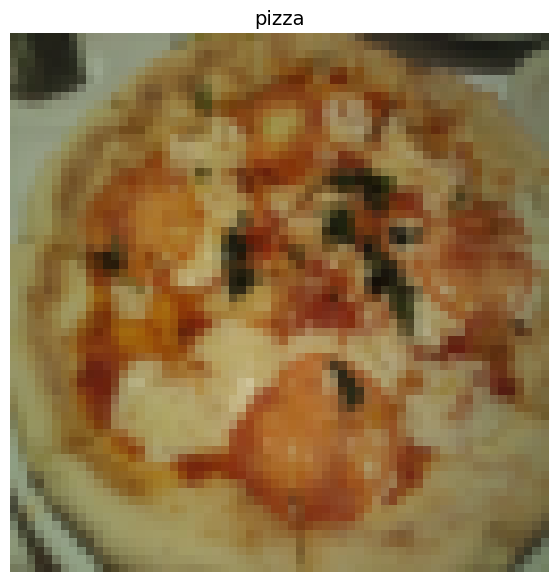

In [17]:
# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(my_pizza_reshaped)
plt.axis("off")
plt.title(class_names[my_label], fontsize=14);

If you remember correctly last TD, after getting our data as a PyTorch `Dataset` we need to turn them into a `DataLoader`.

We'll do so using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Reminder: turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1`.

In [18]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=4,  # how many samples per batch?
    shuffle=True  # shuffle the data?
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=4,
    shuffle=False
) # don't usually need to shuffle testing data

Let's create our neural network

In [19]:
class Net(nn.Module):
    def __init__(self, hidden_units=200):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64*64*3, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 3)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

Let's do a forward pass to test the model when it's not been trained.

In [20]:
def test_our_model():  # no arguments, literally all our variable our globals (not great but it's a notebook)
    # Put model in eval mode
    model.eval()  # to remove stuff like dropout that's only going to be in the training part

    # Setup test accuracy value
    test_acc = 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in test_dataloader:  # majuscule à X car c'est une "matrice", et y un entier
            # 1. Forward pass
            # print(X_test.shape)
            # print(X_test.view(-1, 64*64*3).shape)
            # break
            model_output = model(X_test.view(-1, 64*64*3))

            # 2. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax(dim=1)
            test_acc += (test_pred_label == y_test).sum()  # True == 1, False == 0

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / (test_dataloader.batch_size*len(test_dataloader))
    print(test_acc.item())

test_our_model()

0.36000001430511475


Let's train the model

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)

nbr_epochs: int = 20

def train(optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for epoch in range(nbr_epochs):
        # Loop through data loader data batches
        for X, y in train_dataloader:
            # 1. Forward pass
            y_pred = model(X.view(-1, 64*64*3))

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (train_dataloader.batch_size * len(train_dataloader))
        train_acc = train_acc / (train_dataloader.batch_size * len(train_dataloader))
        print(
            f"epoch {epoch+1}/{nbr_epochs},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%"
        )

In [22]:
train(optimizer_adam)

epoch 1/20, train_loss = 2.72e-01, train_acc = 50.48%
epoch 2/20, train_loss = 2.31e-01, train_acc = 53.87%
epoch 3/20, train_loss = 2.30e-01, train_acc = 55.72%
epoch 4/20, train_loss = 2.21e-01, train_acc = 57.43%
epoch 5/20, train_loss = 2.15e-01, train_acc = 59.98%
epoch 6/20, train_loss = 2.10e-01, train_acc = 61.69%
epoch 7/20, train_loss = 2.05e-01, train_acc = 62.06%
epoch 8/20, train_loss = 2.05e-01, train_acc = 62.87%
epoch 9/20, train_loss = 2.03e-01, train_acc = 63.50%
epoch 10/20, train_loss = 1.98e-01, train_acc = 64.80%
epoch 11/20, train_loss = 2.03e-01, train_acc = 62.80%
epoch 12/20, train_loss = 1.95e-01, train_acc = 65.84%
epoch 13/20, train_loss = 1.89e-01, train_acc = 66.73%
epoch 14/20, train_loss = 1.89e-01, train_acc = 67.40%
epoch 15/20, train_loss = 1.86e-01, train_acc = 68.40%
epoch 16/20, train_loss = 1.83e-01, train_acc = 67.73%
epoch 17/20, train_loss = 1.78e-01, train_acc = 69.88%
epoch 18/20, train_loss = 1.76e-01, train_acc = 68.99%
epoch 19/20, train_

Now let's test our trained model:

In [23]:
test_our_model()

0.5433333516120911


We went from 32% to 54.33% (depends on your seed and the optimizer you used), pretty good with that small of a dataset and that basic of a neural network!

We will "scale up" the number of images in the next class, and we will add some techniques we've seen in the class today to try and improve even more our accuracy!!

Keep in mind though, if you train your data on both optimizers and decide you picked one optimizer because the accuracy on your testing set is better with that optimizer, you've effectively got information from the testing dataset which is not independent anymore, it has therefore inherently become a validation set; and you need an extra independent validation set.

It's just numbers though, let's check the predictions are actually correct on some examples by showing the images, the expected label and the predicted label.

In [24]:
my_iterable = iter(test_dataloader)
X_test_one, y_test_one = next(my_iterable)
print(X_test_one[0][0][0][0])
X_test_one, y_test_one = next(my_iterable)
print(X_test_one[0][0][0][0])

tensor(0.3529)
tensor(0.3412)


Execute this cell several times to iterate through the testing set and see how your model performs:

Predicted class: pizza
Actual class: pizza


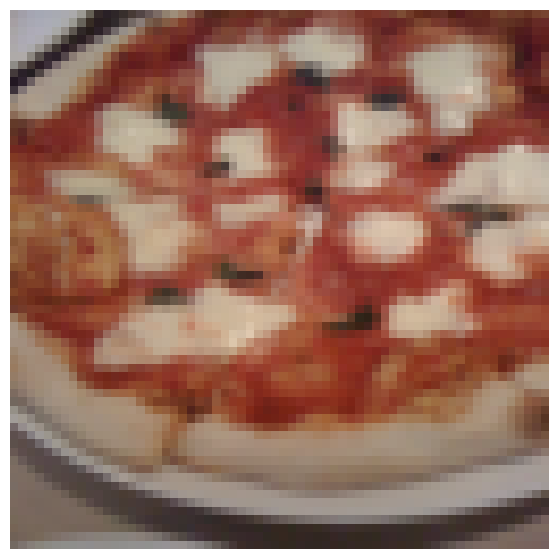

In [25]:
X_test_one_batch, y_test_one_batch = next(my_iterable)
X_test_one, y_test_one = X_test_one_batch[0], y_test_one_batch[0]

# 0. Eval mode
model.eval()

# 1. Forward pass
model_output = model(X_test_one.view(-1, 64*64*3))

# 2. Calculate predicted label
test_pred_label = model_output.argmax()

# 3. Display
print(f"Predicted class: {class_names[test_pred_label]}")
print(f"Actual class: {class_names[y_test_one]}")
plt.figure(figsize=(10, 7))
plt.imshow(X_test_one.permute(1, 2, 0))
_ = plt.axis("off")